# Week 5 — Predict2Optimize

This week is about **putting everything together**.

You will run a portfolio *over time* by combining: prediction, optimization, and backtesting.

There is no single correct solution here! Still some pointers are given.

---

## The loop

> predict returns → optimize portfolio → hold → rebalance → repeat

---

## What you need to do (roughly)

1. **Choose assets and dates**  
   Use a small set of tickers and a reasonable time range.

2. **Build a predictor**  
   Estimate $\hat\mu_t, \hat\Sigma_t$ using past returns only.

   Stick to an easy model - linear predictor for returns, and simple rolling covariance estimate for covariance matrix.

3. **Set a baseline**  
   Examples: 1/N portfolio, or GMVP etc.

4. **Reuse your optimizer**  
   Use your Week 4 Markowitz optimizer.

5. **Write a strategy function**  
   Takes time `t`, past returns, previous weights -> returns new weights. See the howto.

6. **Run the backtest**  
   Choose rebalancing frequency and transaction costs.

7. **Plot diagnostics**
    * Net wealth
    * Daily returns
    * Portfolio weights
    * Turnover
    * ... feel free to extend this, perhaps track the free cash as well?

    > Compare against your baseline.

---

## Common pitfalls

* **Look-ahead bias**
* **Too-frequent rebalancing**
* **Overtrusting predictions**
    - assume some simple uncertainty set and use robust optimization!

---

## Bonus ideas (optional)

* Transaction-cost-aware optimizer (see last bonus section in [howto.ipynb](howto.ipynb))
* Weekly vs monthly rebalancing
* Robust Markowitz
* Rolling Sharpe ratio

---

That’s it. Build a portfolio using the tools you wrote (and the helpers :D)!

Optimize away!
---

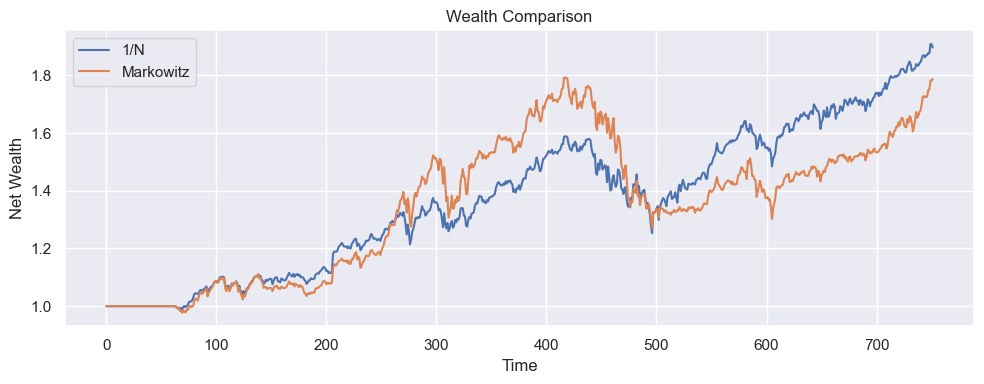

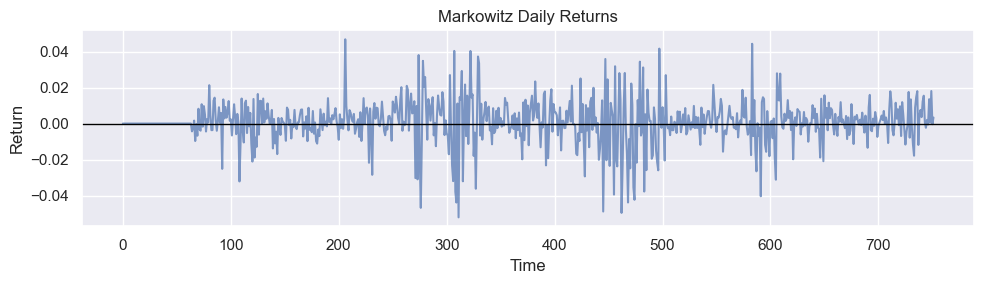

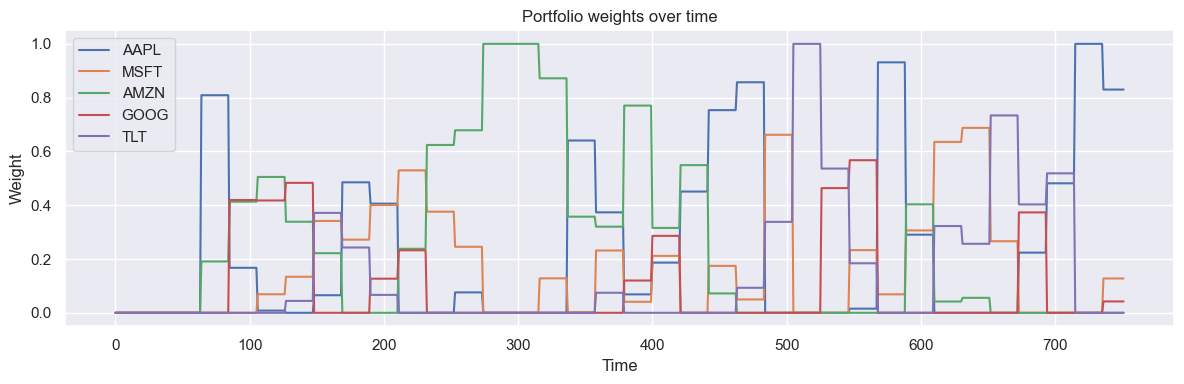

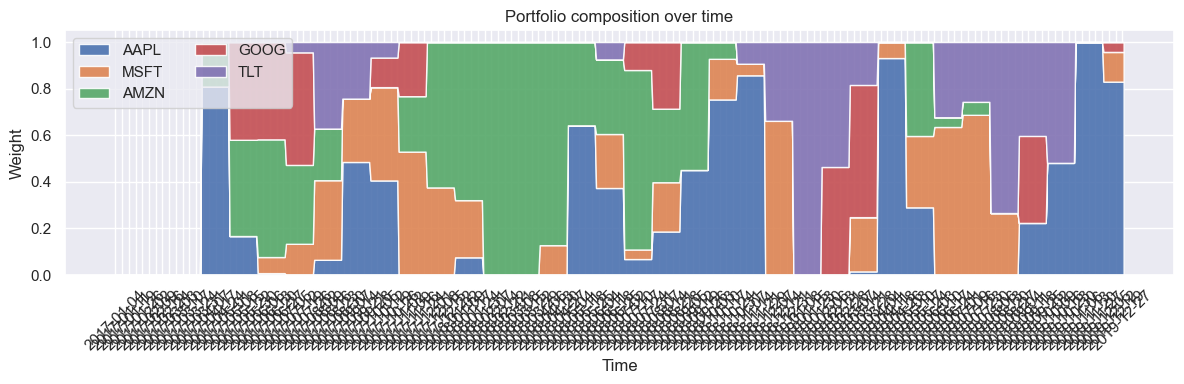

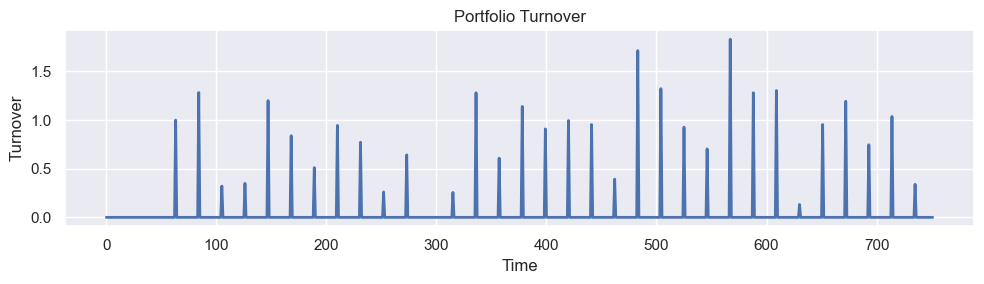

=== Equal Weight ===
Performance summary
-------------------
Total return:     89.62%
Avg daily return: 0.0009
Daily volatility: 0.0103

=== Markowitz ===
Performance summary
-------------------
Total return:     78.73%
Avg daily return: 0.0009
Daily volatility: 0.0122


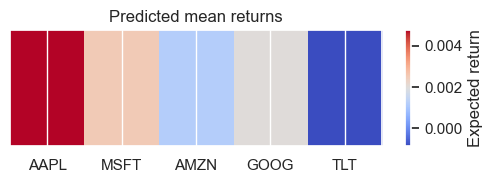

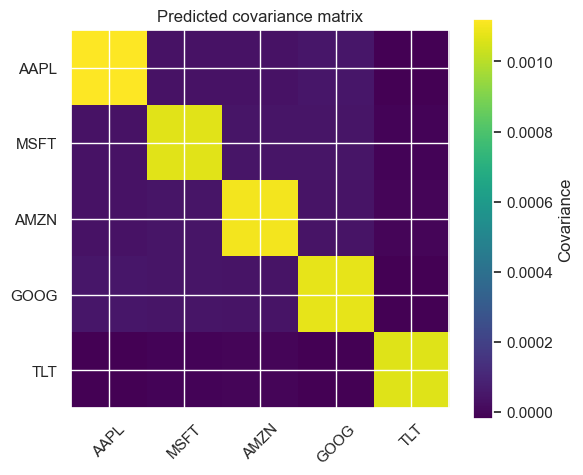

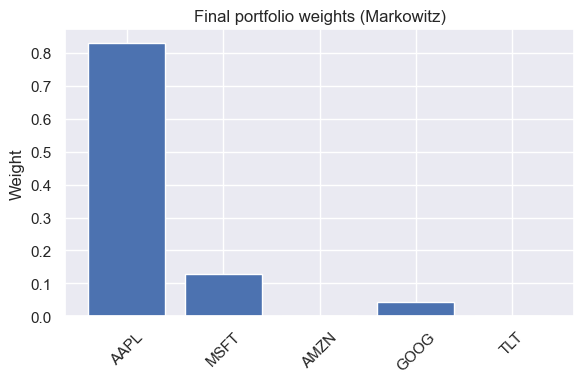

Final portfolio statistics
---------------------------
Expected return : 0.0043
Volatility      : 0.0283
Sharpe ratio    : 0.1534


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp

from backtesting_utils import (
    load_return_data,
    plot_wealth,
    plot_returns,
    plot_weights_over_time,
    plot_weights_stacked_area,
    plot_turnover,
    print_performance_summary
)

from helpers import (
    visualize_single_portfolio,
)

sns.set_theme(style="darkgrid")

def run_backtest(
    returns,                    
    dates,
    initial_wealth,
    strategy_fn,                 
    lookback=60,                 
    rebalance_period=21,          
    transaction_cost_factor=0.0,
):
    returns = np.asarray(returns)
    T, n = returns.shape

    wealth = np.zeros(T)
    cash = np.zeros(T)
    port_returns = np.zeros(T)
    turnover = np.zeros(T)
    weights_hist = np.zeros((T, n))

    wealth[0] = initial_wealth
    wealth[:lookback + 1] = initial_wealth
    cash[:lookback + 1] = initial_wealth
    cash[0] = initial_wealth
    weights = np.zeros(n)

    for t in range(lookback, T - 1):

        if t % rebalance_period == 0:
            target_weights = strategy_fn(t, returns, weights)

            trade = np.abs(target_weights - weights).sum()
            cost = transaction_cost_factor * trade * wealth[t]

            weights = target_weights
            turnover[t] = trade
            cash[t] -= cost
        else:
            cost = 0.0

        port_ret = weights @ returns[t + 1]
        port_returns[t + 1] = port_ret

        wealth[t + 1] = wealth[t] * (1 + port_ret) - cost
        cash[t + 1] = cash[t] * (1 + port_ret) - cost

        weights_hist[t + 1] = weights

    return {
        "wealth": wealth,
        "cash": cash,
        "returns": port_returns,
        "weights": weights_hist,
        "turnover": turnover,
        "dates": dates,
    }

tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "TLT"]
returns_df = load_return_data(
    tickers,
    start="2017-01-01",
    end="2019-12-31",
)

returns = returns_df.values
dates = returns_df.index.astype(str).tolist()
tickers = list(returns_df.columns)
n_assets = len(tickers)

def predict_mu_sigma(returns_window, shrink=1e-3):
    mu_hat = returns_window.mean(axis=0)
    Sigma_hat = np.cov(returns_window, rowvar=False)

    Sigma_hat = 0.5 * (Sigma_hat + Sigma_hat.T)
    Sigma_hat += shrink * np.eye(Sigma_hat.shape[0])
    return mu_hat, Sigma_hat

def markowitz_portfolio(mu, Sigma, lam=1.0):
    n = len(mu)
    w = cp.Variable(n)

    objective = cp.Maximize(mu @ w - lam * cp.quad_form(w, Sigma))
    constraints = [cp.sum(w) == 1, w >= 0]

    prob = cp.Problem(objective, constraints)
    try:
        prob.solve(solver=cp.OSQP, verbose=False)
    except cp.error.SolverError:
        prob.solve(solver=cp.SCS, verbose=False)

    if w.value is None:
        return None, None, None

    w_opt = np.asarray(w.value).reshape(-1)
    exp_ret = mu @ w_opt
    var = w_opt.T @ Sigma @ w_opt
    return w_opt, exp_ret, var

def equal_weight_strategy(t, returns, current_weights):
    n = returns.shape[1]
    return np.ones(n) / n

def markowitz_strategy_fn(t, returns, prev_weights, L=60, lam=1.0):
    window = returns[t - L:t]
    mu_hat, Sigma_hat = predict_mu_sigma(window)

    w_opt, _, _ = markowitz_portfolio(mu_hat, Sigma_hat, lam=lam)
    if w_opt is None or np.any(np.isnan(w_opt)):
        if prev_weights.sum() <= 0:
            return np.ones(returns.shape[1]) / returns.shape[1]
        return prev_weights

    w_opt = np.maximum(w_opt, 0)
    w_opt = w_opt / w_opt.sum()
    return w_opt

lookback = 60
rebalance_period = 21
tc = 0.001
lam = 1.0

results_eq = run_backtest(
    returns=returns,
    dates=dates,
    initial_wealth=1.0,
    strategy_fn=lambda t, r, w: equal_weight_strategy(t, r, w),
    lookback=lookback,
    rebalance_period=rebalance_period,
    transaction_cost_factor=tc,
)

results_mk = run_backtest(
    returns=returns,
    dates=dates,
    initial_wealth=1.0,
    strategy_fn=lambda t, r, w: markowitz_strategy_fn(t, r, w, L=lookback, lam=lam),
    lookback=lookback,
    rebalance_period=rebalance_period,
    transaction_cost_factor=tc,
)

plt.figure(figsize=(10, 4))
plt.plot(results_eq["wealth"], label="1/N")
plt.plot(results_mk["wealth"], label="Markowitz")
plt.title("Wealth Comparison")
plt.xlabel("Time")
plt.ylabel("Net Wealth")
plt.legend()
plt.tight_layout()
plt.show()

plot_returns(results_mk["returns"], title="Markowitz Daily Returns")
plot_weights_over_time(results_mk["weights"], tickers)
plot_weights_stacked_area(results_mk["weights"], tickers, dates)
plot_turnover(results_mk["turnover"])

print("=== Equal Weight ===")
print_performance_summary(results_eq["wealth"], results_eq["returns"])
print("\n=== Markowitz ===")
print_performance_summary(results_mk["wealth"], results_mk["returns"])

mu_last, Sigma_last = predict_mu_sigma(returns[-lookback:])
visualize_single_portfolio(
    mu=mu_last,
    Sigma=Sigma_last,
    w=results_mk["weights"][-1],
    tickers=tickers,
    title_suffix=" (Markowitz)"
)

